In [2]:
from datasets.kitti_dataset import KittiDataset

In [3]:
kitti_dataset_path = '/home/hedgehog/data/unsup_3d_labelling/dataset/'
sequence = '00'
sam_labels_path = '/home/hedgehog/data/unsup_3d_labelling/dataset/vfm-labels/sam/00/'

dataset = KittiDataset(kitti_dataset_path, 
                       sequence, 
                       sam_labels_path)

labels_folder = '/home/hedgehog/Downloads/data_odometry_labels/dataset/sequences/00/labels/'

In [4]:
from segmentation.reprojection_segmentation import ReprojectionSegmentation
from segmentation.dbscan_segmentation import DbscanSegmentation

visual_segmentation = ReprojectionSegmentation(dataset)
geometrical_segmentation = DbscanSegmentation(dataset)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Run baselines

In [5]:
import os
import numpy as np

from tqdm import tqdm

visual_labels = []
geometrical_labels = []
gt_labels = []


for i in tqdm(range(0, len(dataset.poses), 50)):
    visual_labels.append(visual_segmentation.segment_instances(i))
    geometrical_labels.append(geometrical_segmentation.segment_instances(i))
    labels_file_path = os.path.join(labels_folder, '{}.label'.format(str(i).zfill(6)))
    gt_labels.append(np.fromfile(labels_file_path, dtype=np.uint32))


100%|██████████| 91/91 [03:48<00:00,  2.51s/it]


### Visualize baselines

In [23]:
import numpy as np
import open3d as o3d

def color_points_by_labels(points, labels):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    colors = []

    for i in range(labels.shape[0]):
        colors.append(random_colors[int(labels[i]) + 1])

    pcd.colors = o3d.utility.Vector3dVector(np.vstack(colors) / 255)

    return pcd

In [17]:
import random

def generate_random_colors(N):
    colors = []
    for _ in range(N):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

    return colors

random_colors = generate_random_colors(500)

In [27]:
index = 0
points = dataset.get_point_cloud(index)
o3d.visualization.draw_geometries([color_points_by_labels(points, visual_labels[index])])

In [ ]:
o3d.visualization.draw_geometries([color_points_by_labels(points, geometrical_labels[index])])

### Evaluation

In [6]:
import instanseg
from instanseg.metrics import precision, recall, fScore

instanseg.metrics.constants.IOU_THRESHOLD_FULL = 0.5
tp_condition = 'iou'

In [8]:
import pandas as pd

results_dict = []
# for i in tqdm(range(len(visual_labels))):
    res = {
        'index': i,
        'method': 'visual',
        'precision': precision(visual_labels[i], gt_labels[i], tp_condition),
        'recall': recall(visual_labels[i], gt_labels[i], tp_condition),
        'fscore': fScore(visual_labels[i], gt_labels[i], tp_condition)
        
    }
    results_dict.append(res)

    res = {
        'index': i,
        'method': 'geometrical',
        'precision': precision(geometrical_labels[i], gt_labels[i], tp_condition),
        'recall': recall(geometrical_labels[i], gt_labels[i], tp_condition),
        'fscore': fScore(geometrical_labels[i], gt_labels[i], tp_condition)
    }
    results_dict.append(res)


100%|██████████| 91/91 [04:01<00:00,  2.66s/it]


In [9]:
df = pd.DataFrame.from_records(results_dict, index=np.arange(len(results_dict)))

In [10]:
import seaborn as sns

<Axes: xlabel='index', ylabel='recall'>

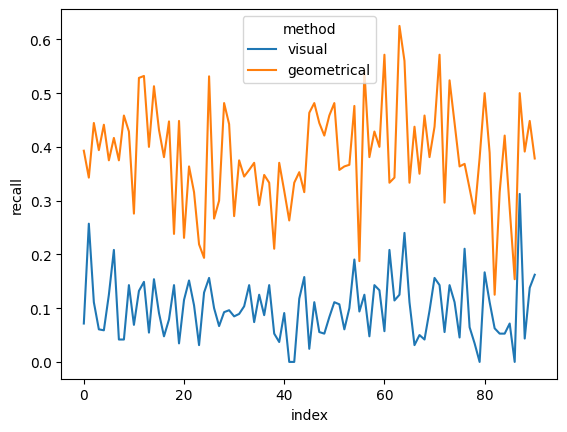

In [12]:
sns.lineplot(df, x='index', y='recall', hue='method')

<Axes: xlabel='index', ylabel='precision'>

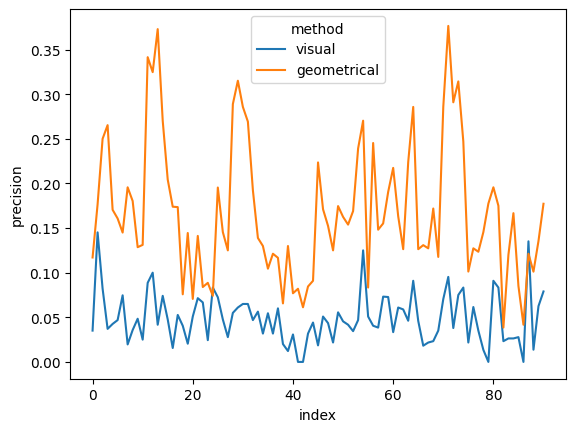

In [13]:
sns.lineplot(df, x='index', y='precision', hue='method')

<Axes: xlabel='index', ylabel='fscore'>

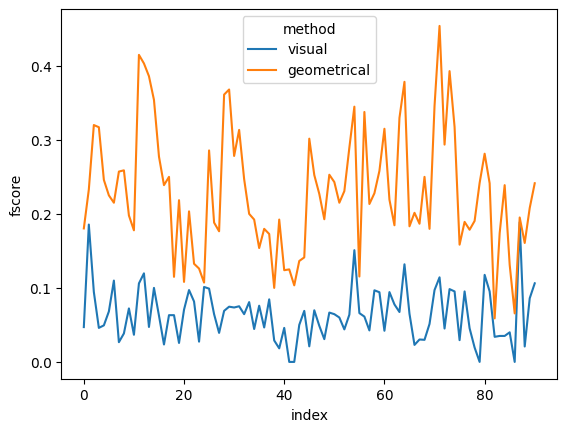

In [15]:
sns.lineplot(df, x='index', y='fscore', hue='method')